In [29]:





import datetime
import pytz
import pandas as pd
import MetaTrader5 as mt5
import matplotlib.pyplot as plt
import numpy as np
import pandas_ta as ta






In [30]:





# 30 min time frame
frameM30 = mt5.TIMEFRAME_M30

#1 min time frame
frameM1 = mt5.TIMEFRAME_M1

# 1 hour time frame
frameH1 = mt5.TIMEFRAME_H1





In [31]:





def getAssetList(assetSet = None):
    assetList = []
    if assetSet == 1:
        assetList = ['EURUSD', 'USDCHF']
    return assetList

        





In [32]:







## Defining the getQuotes method

def getQuotes(mt5TimeFrame, year = 2020, month = 1, day = 1, asset ='EURUSD'):
    
    ## Establishing the connection to MetaTrader 5
    if not mt5.initialize():
        print(f'MT5 initialization failed: Error code = {mt5.last_error}')
        quit()

    # Current time
    currentTime = datetime.datetime.now()

    # Defining the timezone and created utcFrom and utcTo dates
    timeZone = pytz.timezone('Asia/Kolkata')
    utcFrom = datetime.datetime(year, month, day, tzinfo = timeZone)
    utcTo = datetime.datetime(currentTime.year, currentTime.month, currentTime.day, tzinfo = timeZone)
    
    # Retrieving the data and returning it after converting it to pd dataframe
    return pd.DataFrame(mt5.copy_rates_range(asset, mt5TimeFrame, utcFrom, utcTo))







In [33]:



df = getQuotes(frameM30, 2023)
df





,time,open,high,low,close,tick_volume,spread,real_volume
0,1672617600,1.06959,1.07017,1.06936,1.06937,71,54,0
1,1672619400,1.06936,1.06965,1.06883,1.06892,2833,71,0
2,1672621200,1.06892,1.06978,1.06873,1.06968,212,54,0
3,1672623000,1.06968,1.07021,1.06957,1.07021,208,54,0
4,1672624800,1.07012,1.07052,1.06953,1.06965,220,22,0
...,...,...,...,...,...,...,...,...
10112,1698076800,1.06094,1.06128,1.05984,1.06004,3837,9,0
10113,1698078600,1.06004,1.06056,1.05907,1.06048,5901,9,0
10114,1698080400,1.06049,1.06316,1.06044,1.06260,6956,9,0
10115,1698082200,1.06260,1.06299,1.06173,1.06283,6257,9,0


In [34]:


def rsi(df, lookback=21):
    df['rsi'] = ta.rsi(close=df['close'], length=lookback)
    return df



In [35]:

lookback=21

df = rsi(df, lookback)

df


,time,open,high,low,close,tick_volume,spread,real_volume,rsi
0,1672617600,1.06959,1.07017,1.06936,1.06937,71,54,0,NaN
1,1672619400,1.06936,1.06965,1.06883,1.06892,2833,71,0,NaN
2,1672621200,1.06892,1.06978,1.06873,1.06968,212,54,0,NaN
3,1672623000,1.06968,1.07021,1.06957,1.07021,208,54,0,NaN
4,1672624800,1.07012,1.07052,1.06953,1.06965,220,22,0,NaN
...,...,...,...,...,...,...,...,...,...
10112,1698076800,1.06094,1.06128,1.05984,1.06004,3837,9,0,53.998165
10113,1698078600,1.06004,1.06056,1.05907,1.06048,5901,9,0,55.824348
10114,1698080400,1.06049,1.06316,1.06044,1.06260,6956,9,0,63.212590
10115,1698082200,1.06260,1.06299,1.06173,1.06283,6257,9,0,63.900358


In [36]:

buyIndices=[]
sellIndices=[]

buys=[]
sells=[]

position = None

sl = 0.5 / 100
tp = 2.0 / 100

slamount = None
tpamount = None

rsiconstant=3
neutralrsi=50

for i in range(len(df)):
    if (i > 0) and (position is None) and (df.iloc[i]['rsi'] > (neutralrsi + rsiconstant)) and (df.iloc[i - 1]['rsi'] > neutralrsi) and (df.iloc[i - 2]['rsi'] < neutralrsi) and (df.iloc[i - 3]['rsi'] < neutralrsi) and (df.iloc[i - 4]['rsi'] < neutralrsi):
        buyIndices.append(i)
        buys.append(df.iloc[i]['close'])
        position = 'long'
        slamount = df.iloc[i]['close'] - (sl * df.iloc[i]['close'])
        tpamount = df.iloc[i]['close'] + (tp * df.iloc[i]['close'])
    if (i > 0) and (position == 'long') and (
        (
            (df.iloc[i]['rsi'] < (neutralrsi - rsiconstant)) and
            (df.iloc[i - 1]['rsi'] < neutralrsi) and
            (df.iloc[i - 2]['rsi'] > neutralrsi) and
            (df.iloc[i - 3]['rsi'] > neutralrsi) and
            (df.iloc[i - 4]['rsi'] > neutralrsi)
        ) or (
            # (df.iloc[i]['close'] <= slamount)
        ) or (
            (df.iloc[i]['close'] >= tpamount)
        )
    ):
        sellIndices.append(i)
        sells.append(df.iloc[i]['close'])
        position = None
        slamount = None
        tpamount = None




In [37]:

print(buys)
print(sells)

print(buyIndices)
print(sellIndices)


[1.07402, 1.08438, 1.08251, 1.08171, 1.08818, 1.08887, 1.0876, 1.08582, 1.0929, 1.0689899999999999, 1.07043, 1.06064, 1.07033, 1.06874, 1.08427, 1.09228, 1.09163, 1.0994, 1.10366, 1.10664, 1.09833, 1.08776, 1.08463, 1.0791, 1.07356, 1.07191, 1.06895, 1.0772599999999999, 1.09317, 1.09246, 1.08965, 1.09143, 1.08937, 1.08668, 1.0892, 1.10064, 1.12179, 1.10873, 1.10172, 1.09968, 1.09997, 1.09781, 1.09786, 1.09967, 1.09231, 1.08861, 1.08155, 1.08275, 1.08742, 1.07258, 1.06724, 1.05831, 1.05943, 1.05659, 1.05456]
[1.08117, 1.08014, 1.07889, 1.08195, 1.0895299999999999, 1.08757, 1.08655, 1.09445, 1.08481, 1.07242, 1.0657, 1.06025, 1.07093, 1.09034, 1.08906, 1.0903, 1.09606, 1.10219, 1.09811, 1.10088, 1.09104, 1.08648, 1.07748, 1.07638, 1.07224, 1.07077, 1.07629, 1.07535, 1.09135, 1.0977, 1.08897, 1.08978, 1.08733, 1.08524, 1.09833, 1.12292, 1.10805, 1.10588, 1.10114, 1.09916, 1.09785, 1.09706, 1.09795, 1.09769, 1.09174, 1.07712, 1.08084, 1.09069, 1.08079, 1.07314, 1.06863, 1.05103, 1.05518, 1

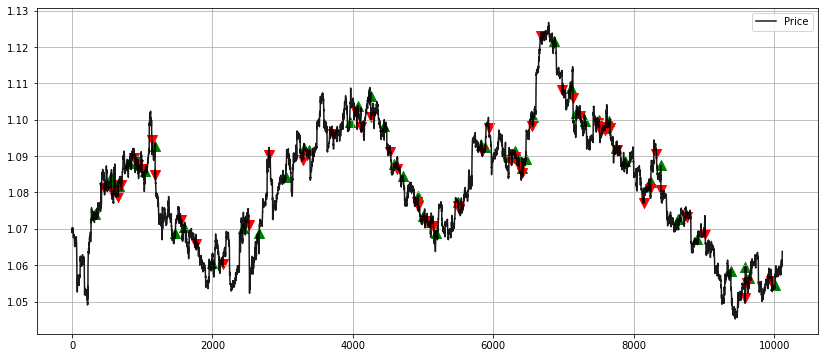

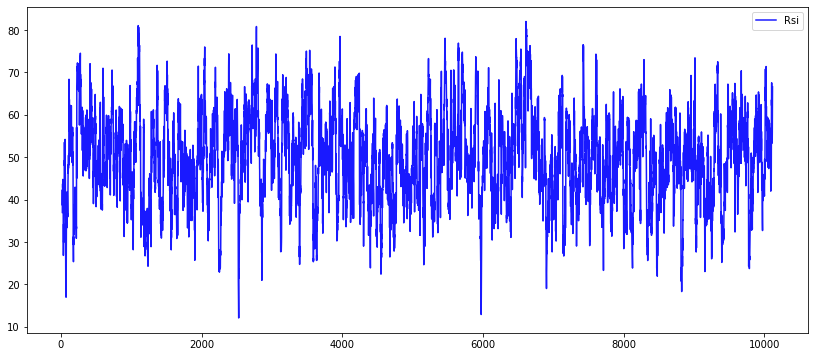

In [38]:


plt.figure(figsize=(14, 6))
plt.plot(df['close'], label='Price', color='black', alpha=0.9)
plt.scatter(df.iloc[buyIndices].index, df.iloc[buyIndices]['close'], marker = '^', color = 'g', s = 100)
plt.scatter(df.iloc[sellIndices].index, df.iloc[sellIndices]['close'], marker = 'v', color = 'r', s = 100)
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize = (14, 6))
plt.plot(df['rsi'], label='Rsi', c='blue', alpha=0.9)
plt.legend()
plt.show()



In [43]:




brokerage = 1 / 100

wins = 0
losses = 0

profit = 0
loss = 0

averageprofit = 0
averageloss = 0

netresult = ''

for i in range(len(sells)):
    maximum = max(sells[i], buys[i])
    brokerageAmount = brokerage * maximum
    diff = sells[i] - buys[i] - brokerageAmount
    if (diff > 0):
        wins += 1
        profit += diff
    if (diff < 0):
        losses += 1
        loss += abs(diff)

if (profit > loss):
    netresult = 'Win'
elif (profit == loss):
    netresult = 'None'
else:
    netresult = 'Loss'

if profit and wins:
    averageprofit = profit / wins

if loss and losses:
    averageloss = loss / losses

hitratio = (wins / (wins + losses)) * 100
profitfactor = (profit / loss)
expectancy = (averageprofit * hitratio) - (averageloss * (1 - hitratio))
riskreward = (averageprofit / averageloss)

print(f'''
    Net result = {netresult}
    Hit ratio = {hitratio} %
    Profit factor = {profitfactor} {{currency}}
    Expectancy = {expectancy} {{currency}}
    Realised risk reward ratio = {riskreward} {{currency}}
''')







    Net result = Loss
    Hit ratio = 3.7037037037037033 %
    Profit factor = 0.03498512914032126 {currency}
    Expectancy = 0.07259357777777767 {currency}
    Realised risk reward ratio = 0.9096133576483527 {currency}

